# Price Demand Elasticity Example
Creation Date 11.23.2019

Julian Hsu


### Objective
The objective is to demonstrate that understanding the identifying variation behind an estimate is crucial for interpretation. We show this by demonstrating how to estimate a classical economics system - supply and demand. The scientific objective is to estimate the supply and demand price elasticity.

This file simulates a demand and supply system, then demonstrates that the naive reduced form
estimate of price elasticity of demand can lead to improper inference. We also try different ML models. These reduced form and ML models will show incorrect answers.
Therefore, a more structural or economics-imposing methodology is necessary.

In [2]:

import numpy as np
import pandas as pd 
import scipy.optimize
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report
from linearmodels.iv import IV2SLS
from linearmodels.iv import IVGMM

import matplotlib.pyplot as plt
%matplotlib notebook


## Simulate a Demand and Supply System.
Simulate a demand and supply system, based on supply/demand cost shifters and unobserved variation in both. The equilibrium price and quantity values are recorded.

Parameters are on an intercept, price, and shifter, and the underlying equation is always in the form of P = f(Q)

In [3]:

N = 500
supply_shifter = np.random.uniform(0,4, N)
unobs_supp_shifter = np.random.normal(supply_shifter,2) + np.random.uniform(-2,2, N)
supply_param = [50, 0.5, 0.2]
demand_shifter = np.random.uniform(0,4, N)
unobs_dema_shifter = np.random.normal(demand_shifter,2) + np.random.uniform(-2,2, N)
demand_param = [120, -1.5, 3 ]
param_dict = {'supply': supply_param, 'demand': demand_param}
price_demand_param = {'true': [demand_param[1], 0] }
data_dict = {'supply_shifter': supply_shifter, 'demand_shifter': demand_shifter, 'unobs_supp': unobs_supp_shifter, 'unobs_dema': unobs_dema_shifter}
data = pd.DataFrame.from_dict(data_dict)


In [13]:
print('Supply Price Elasticity {0}'.format(param_dict['supply'][1]) )
print('Demand Price Elasticity {0}'.format(param_dict['demand'][1]) )


Supply Price Elasticity 0.5
Demand Price Elasticity -1.5


Write a function that solves for the equilibrium price and quantity based on data and parameters. Let's go for a non-linear solver for flexibility.
Also allow unobserved shocks to supply and demand that are correlated with the shifters.


In [4]:
def equilibrium_solver(x, supply_data, supply_unobs, demand_data, demand_unobs, supply_params, demand_params):
    N = len(supply_data)    
    ## Calculate demand price:
    demand_price = demand_params[0] + np.multiply(demand_params[1], x) + np.multiply(demand_params[2], demand_data) + demand_unobs
    ## Calculate supply price:
    supply_price = supply_params[0] + np.multiply(supply_params[1], x) + np.multiply(supply_params[2], supply_data) + supply_unobs
    return demand_price - supply_price

def demand_price(x, demand_data, demand_unobs, demand_params):
    return demand_params[0] + np.multiply(demand_params[1], x) + np.multiply(demand_params[2], demand_data) + demand_unobs

def supply_price(x, supply_data, supply_unobs, supply_params):
    return supply_params[0] + np.multiply(supply_params[1], x) + np.multiply(supply_params[2], supply_data) + supply_unobs

## a bit more readable if your function is very short and you only need it once. 
##See python docs on it. In your case it would be something like     
eq_quant = scipy.optimize.root(equilibrium_solver, np.ones(N) , args=(
data['supply_shifter'], data['unobs_supp'], data['demand_shifter'], data['unobs_dema'], param_dict['supply'], param_dict['demand'] ) , method='broyden1')


In [7]:
print(eq_quant.success)
print(eq_quant.message)
eq_price_D = demand_price(eq_quant.x, data['demand_shifter'], data['unobs_dema'], param_dict['demand'])
eq_price_S = supply_price(eq_quant.x, data['supply_shifter'], data['unobs_supp'], param_dict['supply'])
print(' maximum difference between equilirium prices: {a: 10.7f}'.format(a= np.max(  eq_price_D - eq_price_S) ) )
data['eq_price'] = eq_price_D
data['eq_quant'] = eq_quant.x


True
A solution was found at the specified tolerance.
 maximum difference between equilirium prices:  0.0000000


In [8]:
display('Descriptive Statistics ')
display(data.describe().T)

'Descriptive Statistics '

,count,mean,std,min,25%,50%,75%,max
supply_shifter,500.0,1.986124,1.156877,0.008412,0.947204,1.965273,3.000850,3.995400
demand_shifter,500.0,1.975650,1.142493,0.001327,1.072398,1.956205,2.912096,3.997909
unobs_supp,500.0,2.005487,2.651586,-7.110352,0.067842,2.152567,3.744518,9.839302
unobs_dema,500.0,1.969496,2.474263,-6.602935,0.427439,2.159959,3.599425,8.787974
eq_price,500.0,71.276145,2.359534,63.679592,69.552267,71.272595,72.817020,78.520697
eq_quant,500.0,37.746867,2.922654,30.815597,35.680605,37.671788,39.800786,44.630887


In [ ]:
print('Supply Price Elasticity {0}'.format(param_dict['supply'][1]) )
print('Demand Price Elasticity {0}'.format(param_dict['demand'][1]) )



In [17]:
'''
Now that we have this data, suppose that we are only given the observed equilibrium prices and quantities 
and shifters. What would be two naive estimations of the price elasticity?
'''
model = sm.OLS(data['eq_price'],sm.add_constant(data['eq_quant']))
results = model.fit()
# print(results.summary())
price_demand_param['ols_nocontrols']= [ results.params[1],results.bse[1] ] 

model = sm.OLS(data['eq_price'],sm.add_constant(data[['eq_quant','demand_shifter']]))
results = model.fit()
# print(results.summary())
price_demand_param['ols_wdemandcontrols']= [ results.params[1],results.bse[1] ] 


model = sm.OLS(data['eq_price'],sm.add_constant(data[['eq_quant','supply_shifter']]))
results = model.fit()
# print(results.summary())
price_demand_param['ols_wsupplycontrols']= [ results.params[1],results.bse[1] ] 


model = sm.OLS(data['eq_price'],sm.add_constant(data[['eq_quant','demand_shifter','supply_shifter']]))
results = model.fit()
# print(results.summary())
price_demand_param['ols_wcontrols']= [ results.params[1],results.bse[1] ] 


In [18]:
print('Elasticity based on no control: {0:5.2f} [{1:5.2f}]'.format(price_demand_param['ols_nocontrols'][0],price_demand_param['ols_nocontrols'][1] )  )
print('Elasticity based with demand shifter controls: {0:5.2f} [{1:5.2f}]'.format(price_demand_param['ols_wdemandcontrols'][0],price_demand_param['ols_wdemandcontrols'][1] )  )
print('Elasticity based with supply shifter controls: {0:5.2f} [{1:5.2f}]'.format(price_demand_param['ols_wsupplycontrols'][0],price_demand_param['ols_wsupplycontrols'][1] )  )
print('Elasticity based with both shifter controls: {0:5.2f} [{1:5.2f}]'.format(price_demand_param['ols_wcontrols'][0],price_demand_param['ols_wcontrols'][1] )  )


print('Supply Price Elasticity {0}'.format(param_dict['supply'][1]) )
print('Demand Price Elasticity {0}'.format(param_dict['demand'][1]) )


Elasticity based on no control:  0.01 [ 0.04]
Elasticity based with demand shifter controls: -0.70 [ 0.04]
Elasticity based with supply shifter controls:  0.12 [ 0.03]
Elasticity based with both shifter controls: -0.56 [ 0.05]
Supply Price Elasticity 0.5
Demand Price Elasticity -1.5


## Machine learning version of reduced forms above

Let's include ML models and predict the price based on the observed quantities.
Let's also include different features. For example, whether the demand and supply shifters are 
above 2, and interact them with each other.

We'll do standard cross validation on this dataset. We'll split 100% of the data into:
    60% training, 
    20% testing, and 
    20% validation.


In [24]:

## Do some rough feature engineering here
data['demand_shifter_gr2'] = data['demand_shifter'] >= 2
data['supply_shifter_gr2'] = data['supply_shifter'] >= 2
data['dem_supp_shifter_gr2'] = (data['demand_shifter_gr2']==True) & (data['supply_shifter_gr2']==True)

## Cut the equilibrium quantity and price into discrete categories of 5 to apply a 
## categorical algorithm
data['eq_quant_1bin'] = np.around(data['eq_quant']).astype(np.int32)
data['eq_price_1bin'] = np.around(data['eq_price']).astype(np.int32)

## Now separate into training, testing, and validation sets.
## Because we are doing a continous and categorical version of the outcome,
## create two such sets
features = data[['eq_quant','demand_shifter','supply_shifter', 'demand_shifter_gr2', 'supply_shifter_gr2', 'dem_supp_shifter_gr2']]
y_continuous =  data['eq_price']
y_label = data['eq_price_1bin']

## First split the training set away from the validation+test set
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(features, y_continuous, test_size=0.4)
## Second split the validation and test sets                                                         
X_val_c, X_test_c, y_val_c, y_test_c = train_test_split(features, y_continuous, test_size=0.5)

## First split the training set away from the validation+test set
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(features, y_label, test_size=0.4)
## Second split the validation and test sets                                                         
X_val_l, X_test_l, y_val_l, y_test_l = train_test_split(features, y_label, test_size=0.5)



In [25]:
rf_regress = RandomForestRegressor()
rf_hyparam = {'max_depth': [10,25,50,75,100], 'min_samples_leaf': np.round( np.arange(0.05, 0.45, 0.05), 5 ) }
rf_hyparam['n_estimators'] = np.arange(5,20,5)

def print_results(results, algorithm):
    print('\n For the algorithm: ', algorithm)
    print('  BEST PARAMS: {}'.format(results.best_params_))
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))
        
for a in   [rf_hyparam]      :
    print(a)

{'max_depth': [10, 25, 50, 75, 100], 'min_samples_leaf': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 ]), 'n_estimators': array([ 5, 10, 15])}


In [34]:
'''Random Forests'''
crossval = GridSearchCV(rf_regress, rf_hyparam,cv=5)
crossval.fit(X_train_l, y_train_l)
print_results(crossval,'random forest regressor')
rf_regress_best = crossval.best_estimator_

data['rf_regress_yhat']= rf_regress_best.predict(features)
rf_regress_yhat = data.groupby('eq_quant_1bin')['rf_regress_yhat'].mean().to_frame()






 For the algorithm:  random forest regressor
  BEST PARAMS: {'max_depth': 25, 'min_samples_leaf': 0.05, 'n_estimators': 10}
0.403 (+/-0.136) for {'max_depth': 10, 'min_samples_leaf': 0.05, 'n_estimators': 5}
0.382 (+/-0.179) for {'max_depth': 10, 'min_samples_leaf': 0.05, 'n_estimators': 10}
0.395 (+/-0.108) for {'max_depth': 10, 'min_samples_leaf': 0.05, 'n_estimators': 15}
0.286 (+/-0.146) for {'max_depth': 10, 'min_samples_leaf': 0.1, 'n_estimators': 5}
0.319 (+/-0.163) for {'max_depth': 10, 'min_samples_leaf': 0.1, 'n_estimators': 10}
0.328 (+/-0.124) for {'max_depth': 10, 'min_samples_leaf': 0.1, 'n_estimators': 15}
0.291 (+/-0.114) for {'max_depth': 10, 'min_samples_leaf': 0.15, 'n_estimators': 5}
0.297 (+/-0.139) for {'max_depth': 10, 'min_samples_leaf': 0.15, 'n_estimators': 10}
0.297 (+/-0.134) for {'max_depth': 10, 'min_samples_leaf': 0.15, 'n_estimators': 15}
0.182 (+/-0.081) for {'max_depth': 10, 'min_samples_leaf': 0.2, 'n_estimators': 5}
0.183 (+/-0.129) for {'max_depth'

## Use an instrumental variable (IV) model to estimate elasticities
First estimate the demand elasticity, by instrumenting with the supply shifter. This means that the coefficient estimate is identified from random variation in the supply curve, which thus randomly moves along the demand curve. This therefore creates experimental variation along the demand curve.

In [27]:
'''
Use the IV command from the linearmodels package to structurally estimate 
the demand price coefficient
'''
iv = data['supply_shifter']
x_nonendo = sm.add_constant(data['demand_shifter'])
x_endo = data['eq_quant']
##2SLS IV:
ivmod= IV2SLS(data['eq_price'], x_nonendo , x_endo , iv)
results_2sls = ivmod.fit()
# print(results_2sls.summary)
# print(results_2sls.first_stage)
price_demand_param['iv2sls_supply_shifter']= [ results_2sls.params[2], np.array(results_2sls.cov)[2,2]**(0.5) ] 


In [28]:
for k in list(price_demand_param.keys()):
    print(k)
    print('{a: 5.3f} [{b: 5.3f}]'.format(a=price_demand_param[k][0] , b=price_demand_param[k][1]) ) 
    

true
-1.500 [ 0.000]
ols_nocontrols
 0.010 [ 0.036]
ols_wcontrols
-0.562 [ 0.045]
ols_wdemandcontrols
-0.702 [ 0.044]
ols_wsupplycontrols
 0.120 [ 0.035]
iv2sls_supply_shifter
-1.420 [ 0.133]


<IPython.core.display.Javascript object>


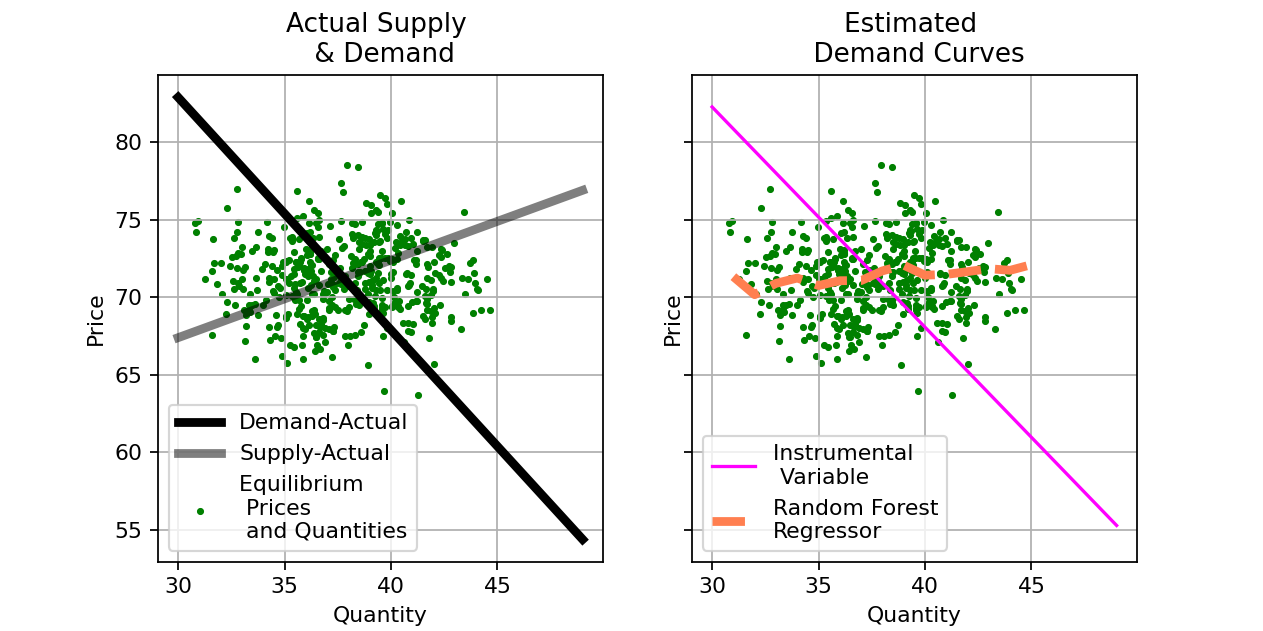

Text(0.5, 1.2, 'Different Approaches to Estimating Demand')

In [46]:
'''
To further illustrate our point, plot the demand and supply curves, 
the equilibrium prices and quantities,
and what the estimated demand curves are.

Figure out what line to plot - we have the slopes but need 
the right intercept because there are factors other than price and 
quantity.
'''
import matplotlib.pyplot as plt
%matplotlib notebook

intercept = {}
intercept['true demand'] = np.average(data['eq_price']) - np.multiply(price_demand_param['true'][0], np.average(data['eq_quant']) )
intercept['ols demand'] = np.average(data['eq_price']) - np.multiply(price_demand_param['ols_wcontrols'][0], np.average(data['eq_quant']) )
intercept['iv demand'] = np.average(data['eq_price']) - np.multiply(price_demand_param['iv2sls_supply_shifter'][0], np.average(data['eq_quant']) )
intercept['true supply'] = np.average(data['eq_price']) - np.multiply(supply_param[1], np.average(data['eq_quant']) )


x_range = np.arange(30,50)

f, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(8,4))
ax[0].plot( x_range, intercept['true demand']+price_demand_param['true'][0]*x_range, c='black', linewidth=4, label='Demand-Actual')
ax[0].plot( x_range, intercept['true supply']+supply_param[1]*x_range, c='black', linewidth=4,alpha=0.50, label='Supply-Actual')
ax[0].scatter( data['eq_quant'], data['eq_price'], s=5, c='green', label='Equilibrium \n Prices \n and Quantities')
ax[0].set_xlabel('Quantity')
ax[0].set_ylabel('Price')
ax[0].legend(loc='lower left')
ax[0].set_title('Actual Supply \n & Demand')
ax[0].grid()

# ax[1].plot( x_range, intercept['ols demand']+price_demand_param['ols_wcontrols'][0]*x_range, c='blue', linewidth=4, label='OLS')
ax[1].plot( x_range, intercept['iv demand']+price_demand_param['iv2sls_supply_shifter'][0]*x_range, c='magenta', label='Instrumental \n Variable')
ax[1].plot( rf_regress_yhat.index, rf_regress_yhat, c='coral', linestyle='--', linewidth=4, label='Random Forest\nRegressor')

ax[1].scatter( data['eq_quant'], data['eq_price'], s=5, c='green')
ax[1].set_xlabel('Quantity')
ax[1].set_ylabel('Price')
ax[1].legend(loc='lower left')
ax[1].set_title('Estimated \n Demand Curves')
ax[1].grid()

# ax[1].plot( rf_regress_yhat.index, rf_regress_yhat, c='coral', linestyle='--', linewidth=4, label='Random Forest\nRegressor')
# ax[1].scatter( data['eq_quant'], data['eq_price'], s=5, c='green')
# ax[1].set_xlabel('Quantity')
# ax[1].set_ylabel('Price')
# ax[1].legend(loc='lower left')
# ax[1].set_title('ML Estimated \n Demand Curves')
# ax[1].grid()

f.suptitle('Different Approaches to Estimating Demand', y=1.2, fontsize=16)
